# Composition to Microstructure Sensitivity Pipeline

This notebook provides an interactive view of the surrogate modeling and sensitivity analysis in: Al Jame, Shao, Dong, Karve, Mumm, Mahadevan, Webler, Rollett, Mahadevan, Sun, Taheri-Mousavi, Global sensitivity analysis for microstructural features to elemental concentration variability in additively manufactured alloy 718, Acta Materiala (under review).  The notebook reproduces s the original Python script in a step‑by‑step format.

* **Goal**: Predict γ′ phase fraction from alloy composition and analyse element sensitivities.
* **Method**: Polynomial Chaos Expansion (PCE) surrogate model with Sobol sensitivity indices.
* **Data**: An HDF5 filecreated with ThermoCalc and  containing element mass fractions and measured phase fractions..

In [1]:

# 1. Imports & environment setup                                              


import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Surrogate modelling
import chaospy as cp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Plotting defaults for notebook
%matplotlib inline
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold'})
sns.set_style('whitegrid')


## 2. Load the dataset from HDF5

Change `hdf5_path` if your data file has a different name or location. The file is expected to contain three datasets:

* **`composition`** — 2‑D array of mass fractions (Ni, Cr, Nb, Mo, Ti, Al, Co)
* **`g_prime`** — γ′ phase fraction (float per alloy)
* **`g_dprime`** — γ′′ phase fraction (float per alloy)  

The loader converts these to NumPy arrays for further processing.

In [2]:
# 2 · Data ingestion                                                           #


hdf5_path = "Phase_fraction_data.hdf5"   # edit if your file lives elsewhere

with h5py.File(hdf5_path, "r") as f:
    # 7 mass-fraction columns for each alloying element
    composition_mass = np.asarray(f["conc"],      dtype=np.float32)
    
    # overall phase fractions
    g_prime  = np.asarray(f["g_prime"],  dtype=np.float32)
    g_dprime = np.asarray(f["g_dprime"], dtype=np.float32)
    
    # optional: the “Matrix” dataset—useful later if you want γ matrix %
    matrix   = np.asarray(f["Matrix"],   dtype=np.float32)

print("Loaded datasets:")
print("  composition_mass:", composition_mass.shape)
print("  g_prime:",          g_prime.shape)
print("  g_dprime:",         g_dprime.shape)
print("  matrix:",           matrix.shape)


Loaded datasets:
  composition_mass: (495000, 7)
  g_prime: (495000,)
  g_dprime: (495000,)
  matrix: (495000,)


In [3]:
import h5py, pprint, textwrap

hdf5_path = "Phase_fraction_data.hdf5"

def walk(name, obj, pad=""):
    if isinstance(obj, h5py.Dataset):
        print(f"{pad}{name}  ->  dataset  {obj.shape}  {obj.dtype}")
    else:                              # it’s a Group
        print(f"{pad}{name}/")
        for k, v in obj.items():
            walk(k, v, pad + "    ")

with h5py.File(hdf5_path, "r") as f:
    walk("/", f)

//
    Matrix  ->  dataset  (495000,)  float32
    conc  ->  dataset  (495000, 7)  float32
    g_dprime  ->  dataset  (495000,)  float32
    g_prime  ->  dataset  (495000,)  float32


## 3. Convert mass fractions to mole fractions and build a dataframe

Conversion uses atomic weights and assumes iron (Fe) is the balance element.  Values are expressed as *mole %*.

In [4]:
# 3. Mass-→mole conversion                                                     

atomic_weights = {
    'Fe': 55.845, 'Ni': 58.69, 'Cr': 52.00, 'Nb': 92.90,
    'Mo': 95.95, 'Ti': 47.867, 'Al': 26.98154, 'Co': 58.933
}

Ni, Cr, Nb, Mo, Ti, Al, Co = ([] for _ in range(7))

for row in composition_mass:
    Fe_mass = 1.0 - row.sum()        # balancing Fe mass fraction
    m_total = (
        Fe_mass / atomic_weights['Fe']
        + row[0] / atomic_weights['Ni']
        + row[1] / atomic_weights['Cr']
        + row[2] / atomic_weights['Nb']
        + row[3] / atomic_weights['Mo']
        + row[4] / atomic_weights['Ti']
        + row[5] / atomic_weights['Al']
        + row[6] / atomic_weights['Co']
    )

    Ni.append(row[0] / atomic_weights['Ni'] / m_total * 100)
    Cr.append(row[1] / atomic_weights['Cr'] / m_total * 100)
    Nb.append(row[2] / atomic_weights['Nb'] / m_total * 100)
    Mo.append(row[3] / atomic_weights['Mo'] / m_total * 100)
    Ti.append(row[4] / atomic_weights['Ti'] / m_total * 100)
    Al.append(row[5] / atomic_weights['Al'] / m_total * 100)
    Co.append(row[6] / atomic_weights['Co'] / m_total * 100)

df = pd.DataFrame({
    "Ni (mole %)": Ni, "Cr (mole %)": Cr, "Nb (mole %)": Nb,
    "Al (mole %)": Al, "Ti (mole %)": Ti, "Co (mole %)": Co,
    "Mo (mole %)": Mo, "γ′ (mole %)": g_prime, "γ′′ (mole %)": g_dprime
})

df.head()


,Ni (mole %),Cr (mole %),Nb (mole %),Al (mole %),Ti (mole %),Co (mole %),Mo (mole %),γ′ (mole %),γ′′ (mole %)
0,54.196907,19.345301,3.145006,0.511190,1.196706,0.046765,1.724961,4.024040,12.897523
1,51.287556,20.664402,3.284360,0.664811,1.318909,0.056972,1.741109,6.361677,12.389036
2,52.947201,20.872257,3.399785,0.605983,1.298972,0.648687,1.780184,5.780715,13.233280
3,51.374519,21.389687,3.357905,0.446291,0.942980,0.894003,1.860440,1.487730,15.139118
4,53.326088,21.488224,3.160228,0.453082,1.357119,0.682404,1.744798,3.520830,12.832091


## 4. Explore variable distributions

The next cell plots histograms with KDE curves for each composition and phase‑fraction column.

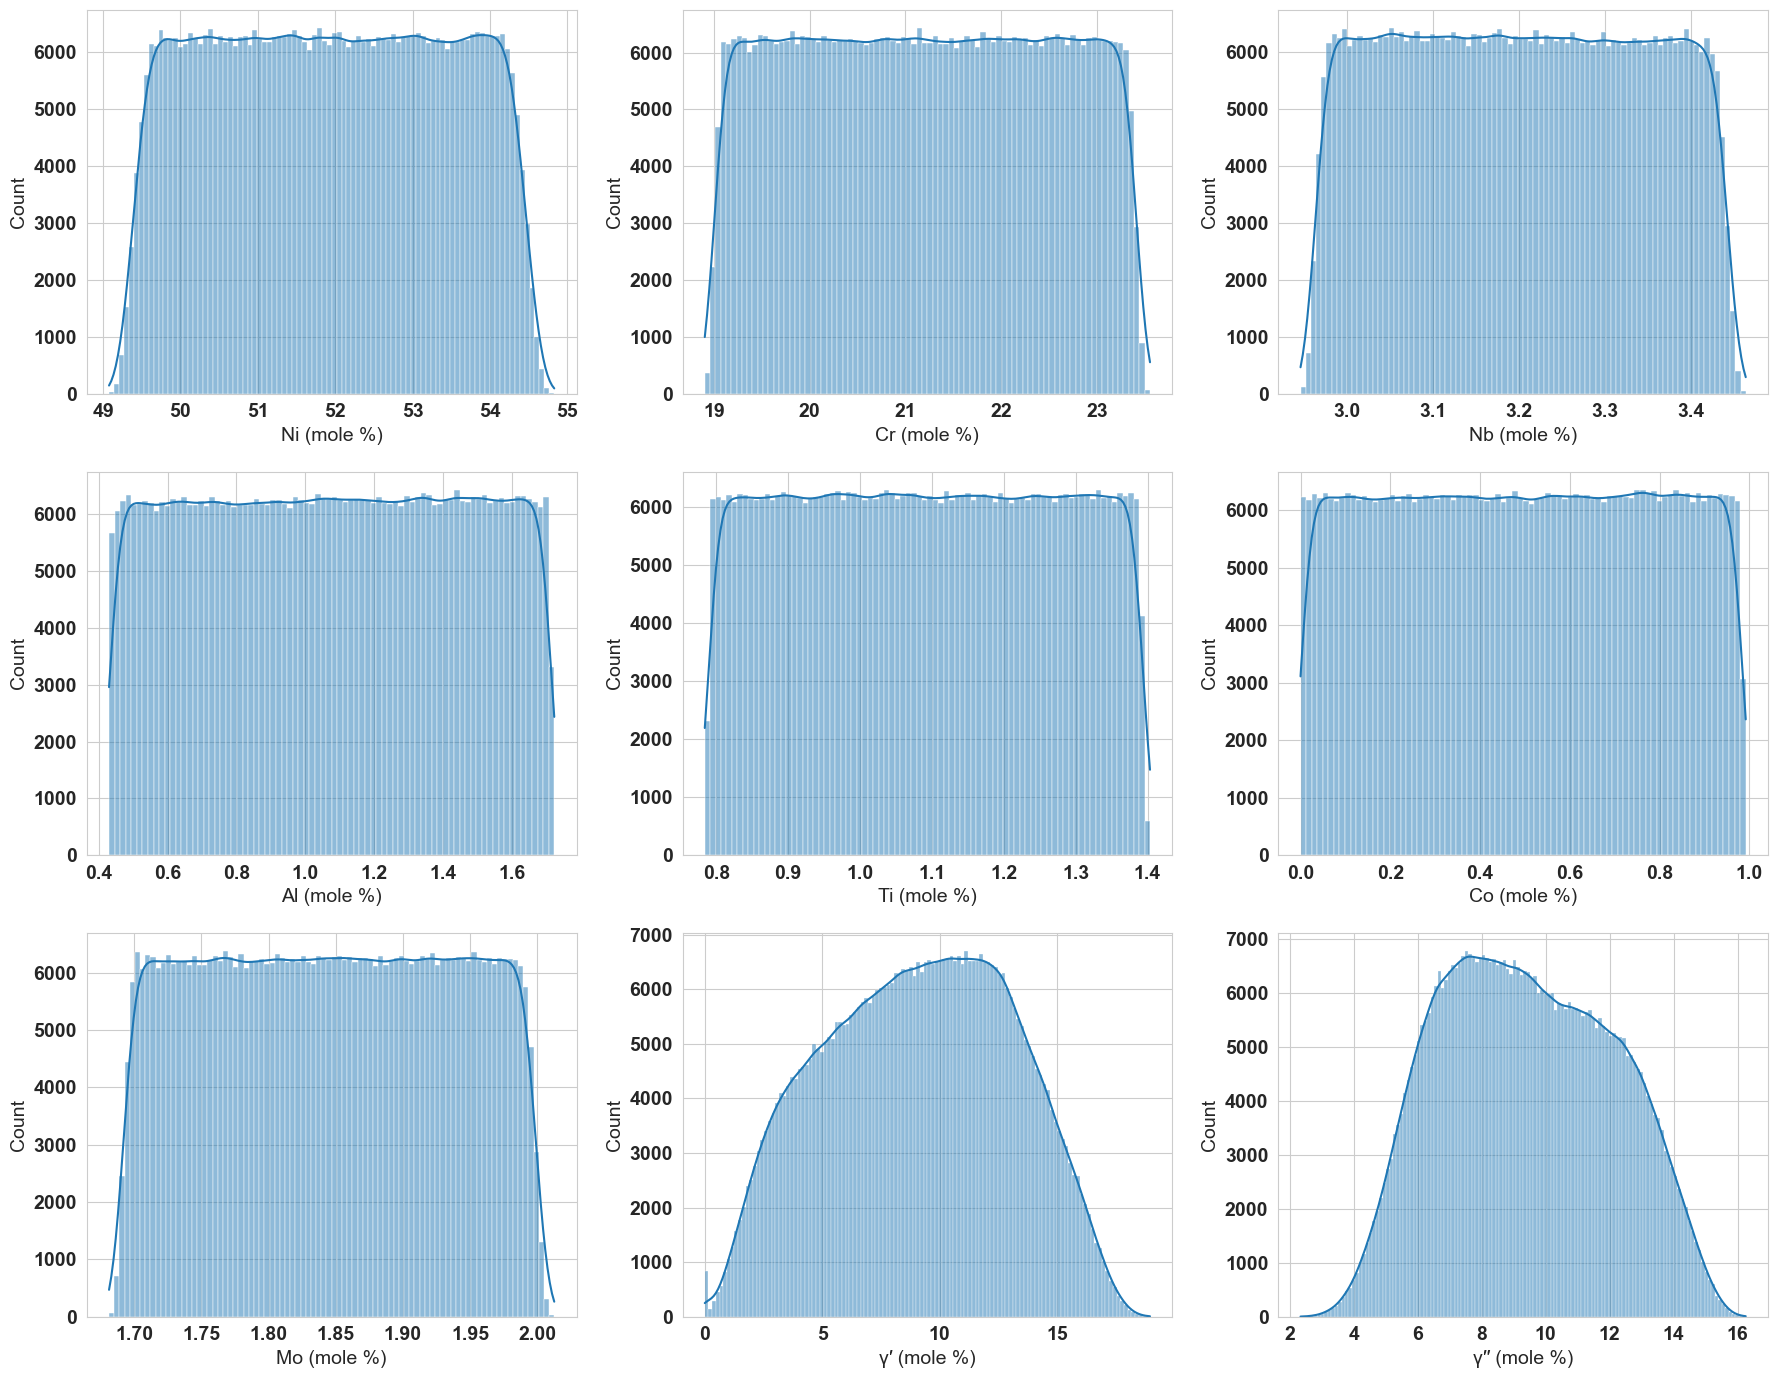

In [5]:
# 4. Visualise distributions                                                  

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()

for ax, column in zip(axes, df.columns):
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


## 5. Prepare inputs & target for PCE surrogate

* **Features (X)**: first seven columns (element mole %).
* **Target (y)**: γ′ mole %.

Uniform distributions are defined across the observed range of each feature and combined into an independent joint distribution.

In [6]:
# 5. Feature/target arrays + distributions                                     


X = df.iloc[:, 0:7].values.astype('float64')
y = df['γ′ (mole %)'].values.astype('float64')

dists = [
    cp.Uniform(df[col].min(), df[col].max())
    for col in df.columns[:7]
]
joint_dist = cp.J(*dists)

# Train/val/test split: 80/10/10
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42
)
print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)


Train: (396004, 7)  Val: (49496, 7)  Test: (49500, 7)


## 6. Hyper‑parameter search for polynomial order

Loop over candidate orders (1 to 4), fit a PCE on the training set, predict on the validation set, and store metrics.

In [7]:
# 6. Polynomial order sweep                                                    


orders = range(1, 5)
val_mse, val_r2 = [], []

for order in orders:
    poly = cp.expansion.stieltjes(order, joint_dist)
    model = cp.fit_regression(poly, X_train.T, y_train)
    y_pred = model(*X_val.T)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    val_mse.append(mse)
    val_r2.append(r2)
    print(f"Order {order}: val MSE={mse:.4f}, R²={r2:.4f}")

best_order = orders[int(np.argmin(val_mse))]
print("\nSelected polynomial order:", best_order)


Order 1: val MSE=0.5825, R²=0.9633
Order 2: val MSE=0.4578, R²=0.9711
Order 3: val MSE=0.3874, R²=0.9756
Order 4: val MSE=0.3210, R²=0.9798

Selected polynomial order: 4


## 7. Train final PCE & evaluate on hold‑out test set

Test MSE=0.3418, R²=0.9784


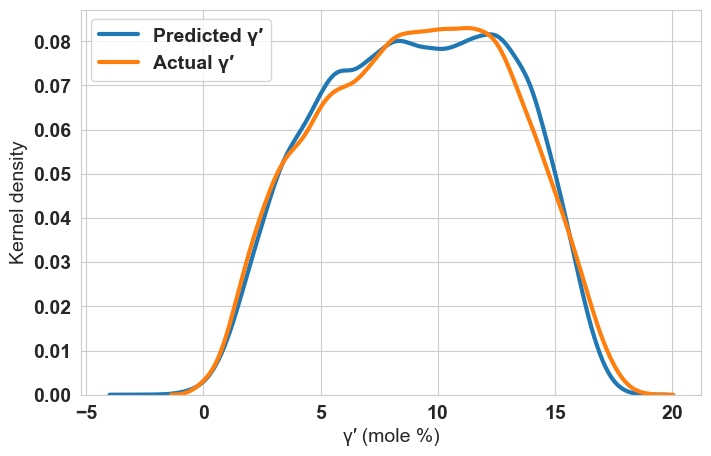

In [8]:
#7. Final model fit & test evaluation                                         

poly_final = cp.expansion.stieltjes(best_order, joint_dist)
model_final = cp.fit_regression(poly_final, X_train.T, y_train)

y_test_pred = model_final(*X_test.T)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE={test_mse:.4f}, R²={test_r2:.4f}")

# KDE overlay
plt.figure(figsize=(8,5))
sns.kdeplot(y_test_pred, linewidth=3, label="Predicted γ′")
sns.kdeplot(y_test, linewidth=3, label="Actual γ′")
plt.xlabel("γ′ (mole %)")
plt.ylabel("Kernel density")
plt.legend()
plt.show()


## 8. Global sensitivity analysis (Sobol indices)

Chaospy can compute Sobol indices directly from the fitted PCE coefficients.

,Element,Main,Total
0,Ni,0.009367,0.010580
1,Cr,0.007713,0.008278
2,Nb,0.001094,0.006808
3,Al,0.858087,0.868444
4,Ti,0.111479,0.120790
5,Co,0.000289,0.000317
6,Mo,0.000013,0.000033


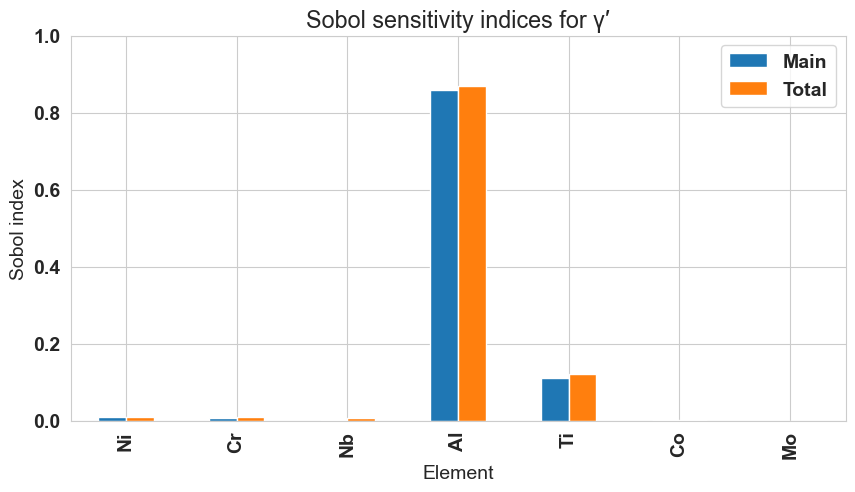

In [10]:
#8. Sobol sensitivity indices                                                 

main_sobol = cp.Sens_m(model_final, joint_dist)
total_sobol = cp.Sens_t(model_final, joint_dist)

elements = ['Ni', 'Cr', 'Nb', 'Al', 'Ti', 'Co', 'Mo']
sobol_df = pd.DataFrame({
    'Element': elements,
    'Main': main_sobol,
    'Total': total_sobol
})

display(sobol_df)

# Bar plot
sobol_df.set_index('Element').plot.bar(figsize=(10,5))
plt.title("Sobol sensitivity indices for γ′")
plt.ylabel("Sobol index")
plt.ylim(0, 1)
plt.show()


## 9. Possible Next Steps

* **γ′′ modelling**: Repeat Section 5‑8 with `y = df['γ′′ (mole %)']`.
* **Better distributions**: Replace uniform priors with empirical or kernel‑density estimates.
* **Interaction visualisations**: Explore pairwise elemental effects using partial‑dependence or ALE plots.



# Try for recalculated dataset

In [11]:
# 2 · Data ingestion                                                           #


hdf5_path = "Phase_fraction_data_v2.hdf5"   # edit if your file lives elsewhere

with h5py.File(hdf5_path, "r") as f:
    # 7 mass-fraction columns for each alloying element
    composition_mass = np.asarray(f["conc"],      dtype=np.float32)
    
    # overall phase fractions
    g_prime  = np.asarray(f["g_prime"],  dtype=np.float32)
    g_dprime = np.asarray(f["g_dprime"], dtype=np.float32)
    
    # optional: the “Matrix” dataset—useful later if you want γ matrix %
    matrix   = np.asarray(f["Matrix"],   dtype=np.float32)

print("Loaded datasets:")
print("  composition_mass:", composition_mass.shape)
print("  g_prime:",          g_prime.shape)
print("  g_dprime:",         g_dprime.shape)
print("  matrix:",           matrix.shape)


Loaded datasets:
  composition_mass: (500000, 7)
  g_prime: (500000,)
  g_dprime: (500000,)
  matrix: (500000,)


In [12]:
import h5py, pprint, textwrap

hdf5_path = "Phase_fraction_data.hdf5"

def walk(name, obj, pad=""):
    if isinstance(obj, h5py.Dataset):
        print(f"{pad}{name}  ->  dataset  {obj.shape}  {obj.dtype}")
    else:                              # it’s a Group
        print(f"{pad}{name}/")
        for k, v in obj.items():
            walk(k, v, pad + "    ")

with h5py.File(hdf5_path, "r") as f:
    walk("/", f)

//
    Matrix  ->  dataset  (495000,)  float32
    conc  ->  dataset  (495000, 7)  float32
    g_dprime  ->  dataset  (495000,)  float32
    g_prime  ->  dataset  (495000,)  float32


In [13]:
# 3. Mass-→mole conversion                                                     

atomic_weights = {
    'Fe': 55.845, 'Ni': 58.69, 'Cr': 52.00, 'Nb': 92.90,
    'Mo': 95.95, 'Ti': 47.867, 'Al': 26.98154, 'Co': 58.933
}

Ni, Cr, Nb, Mo, Ti, Al, Co = ([] for _ in range(7))

for row in composition_mass:
    Fe_mass = 1.0 - row.sum()        # balancing Fe mass fraction
    m_total = (
        Fe_mass / atomic_weights['Fe']
        + row[0] / atomic_weights['Ni']
        + row[1] / atomic_weights['Cr']
        + row[2] / atomic_weights['Nb']
        + row[3] / atomic_weights['Mo']
        + row[4] / atomic_weights['Ti']
        + row[5] / atomic_weights['Al']
        + row[6] / atomic_weights['Co']
    )

    Ni.append(row[0] / atomic_weights['Ni'] / m_total * 100)
    Cr.append(row[1] / atomic_weights['Cr'] / m_total * 100)
    Nb.append(row[2] / atomic_weights['Nb'] / m_total * 100)
    Mo.append(row[3] / atomic_weights['Mo'] / m_total * 100)
    Ti.append(row[4] / atomic_weights['Ti'] / m_total * 100)
    Al.append(row[5] / atomic_weights['Al'] / m_total * 100)
    Co.append(row[6] / atomic_weights['Co'] / m_total * 100)

df = pd.DataFrame({
    "Ni (mole %)": Ni, "Cr (mole %)": Cr, "Nb (mole %)": Nb,
    "Al (mole %)": Al, "Ti (mole %)": Ti, "Co (mole %)": Co,
    "Mo (mole %)": Mo, "γ′ (mole %)": g_prime, "γ′′ (mole %)": g_dprime
})

df.head()

,Ni (mole %),Cr (mole %),Nb (mole %),Al (mole %),Ti (mole %),Co (mole %),Mo (mole %),γ′ (mole %),γ′′ (mole %)
0,65.691841,24.816202,3.870435,0.521761,0.992974,3.645802,0.460889,0.084633,0.146871
1,64.830414,25.272820,3.479064,1.369589,1.082169,3.515040,0.450817,0.090918,0.129781
2,64.756493,25.554836,3.637113,1.395211,0.924077,3.329622,0.402540,0.069537,0.142452
3,63.819557,26.602205,3.884321,0.805913,0.987461,3.420676,0.479768,0.091288,0.144077
4,65.454193,25.201324,3.538099,1.262990,1.017170,3.136605,0.389509,0.072655,0.138345


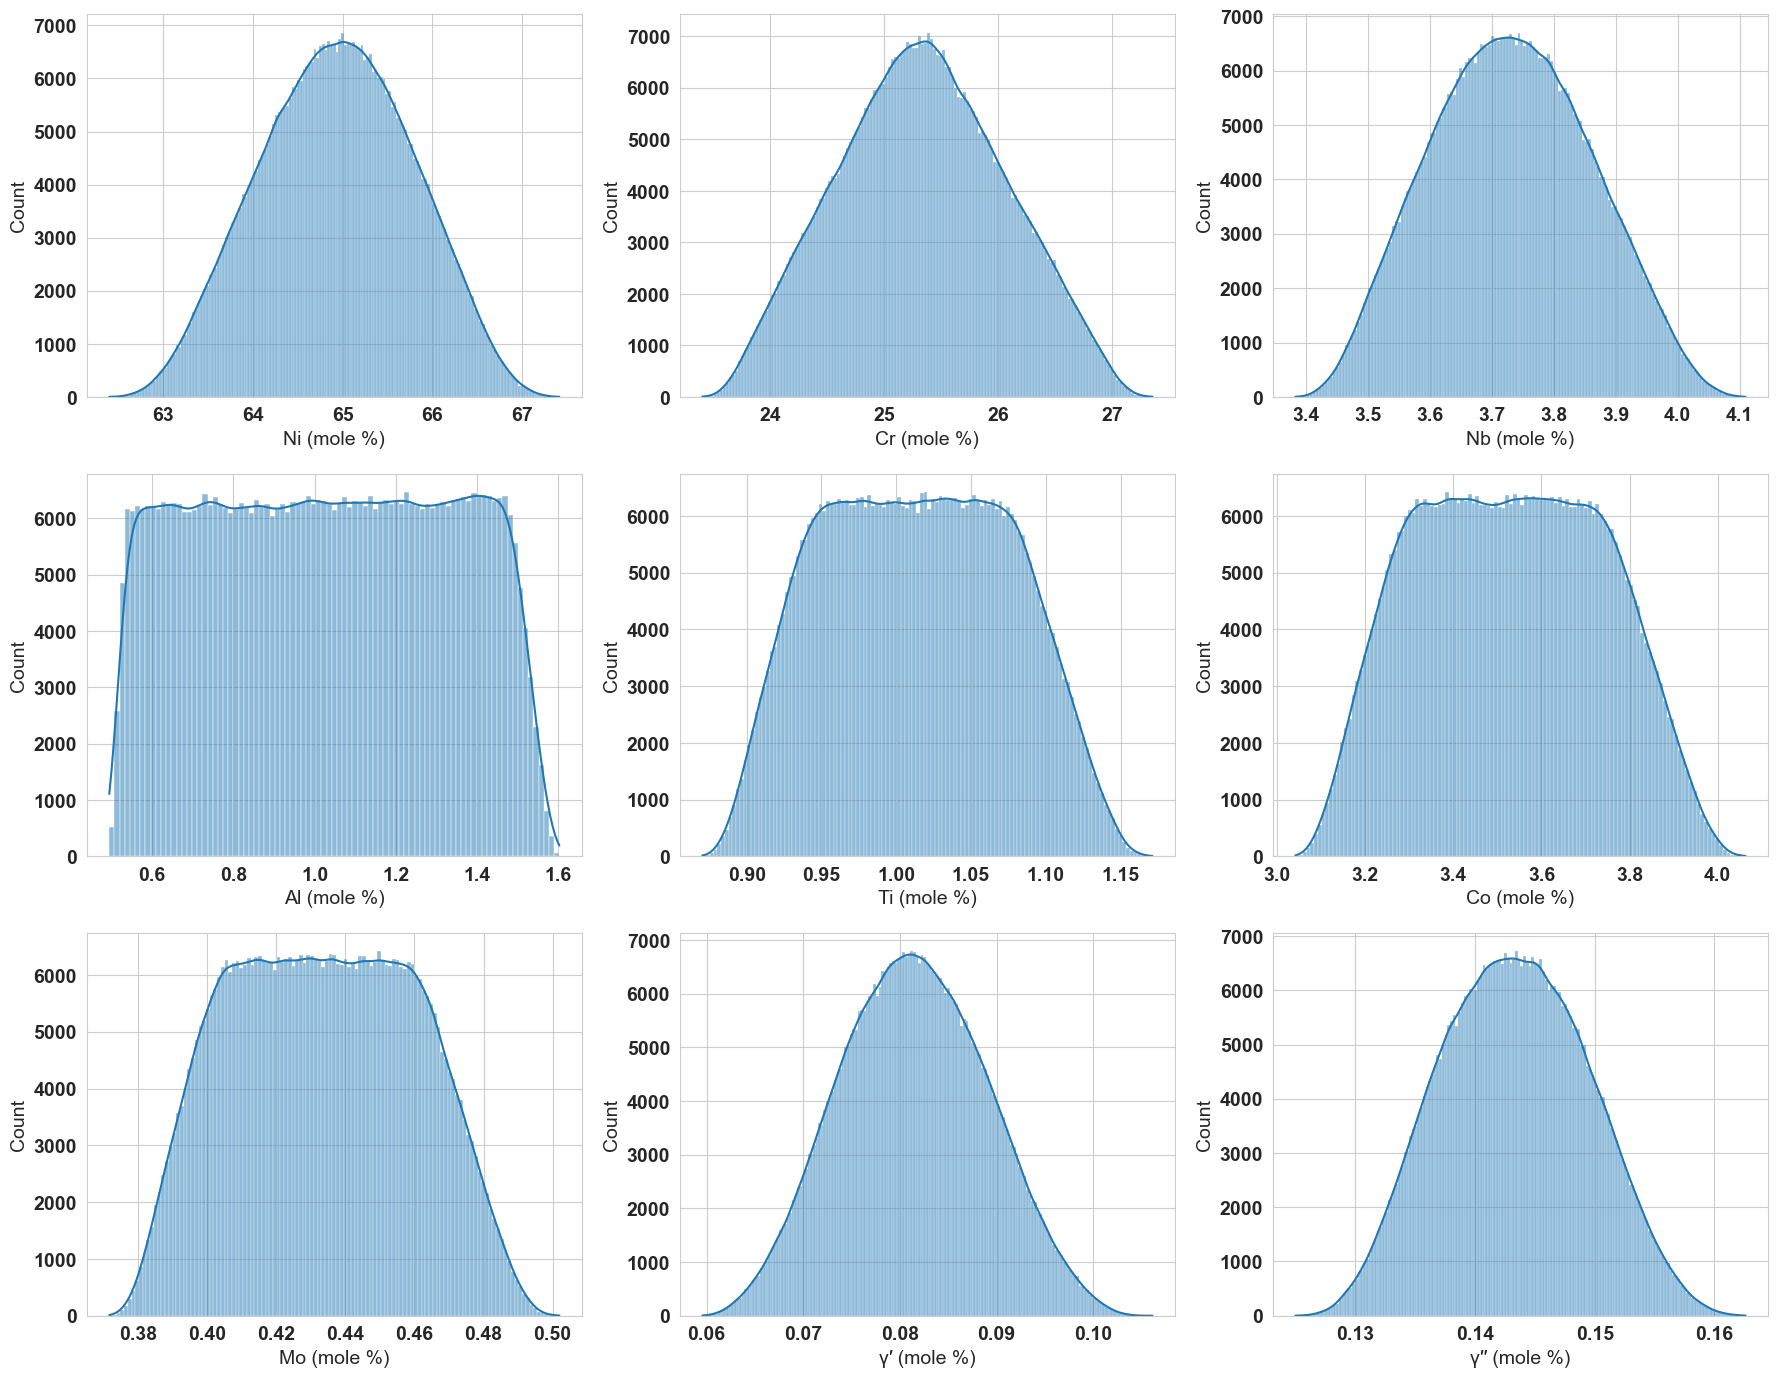

In [14]:
# 4. Visualise distributions                                                  

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()

for ax, column in zip(axes, df.columns):
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [15]:
# 5. Feature/target arrays + distributions                                     


X = df.iloc[:, 0:7].values.astype('float64')
y = df['γ′ (mole %)'].values.astype('float64')

dists = [
    cp.Uniform(df[col].min(), df[col].max())
    for col in df.columns[:7]
]
joint_dist = cp.J(*dists)

# Train/val/test split: 80/10/10
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42
)
print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)


Train: (400005, 7)  Val: (49995, 7)  Test: (50000, 7)


Test MSE=0.0000, R²=1.0000


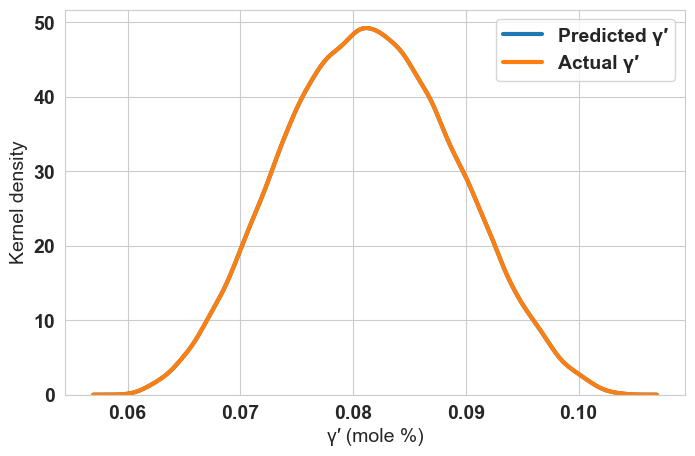

In [16]:
#7. Final model fit & test evaluation                                         

poly_final = cp.expansion.stieltjes(best_order, joint_dist)
model_final = cp.fit_regression(poly_final, X_train.T, y_train)

y_test_pred = model_final(*X_test.T)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE={test_mse:.4f}, R²={test_r2:.4f}")

# KDE overlay
plt.figure(figsize=(8,5))
sns.kdeplot(y_test_pred, linewidth=3, label="Predicted γ′")
sns.kdeplot(y_test, linewidth=3, label="Actual γ′")
plt.xlabel("γ′ (mole %)")
plt.ylabel("Kernel density")
plt.legend()
plt.show()

,Element,Main,Total
0,Ni,0.560425,0.866647
1,Cr,0.110510,0.371172
2,Nb,0.001336,-0.130937
3,Al,0.002583,-0.022740
4,Ti,0.001273,-0.121034
5,Co,0.002033,-0.053549
6,Mo,0.004276,-0.122501


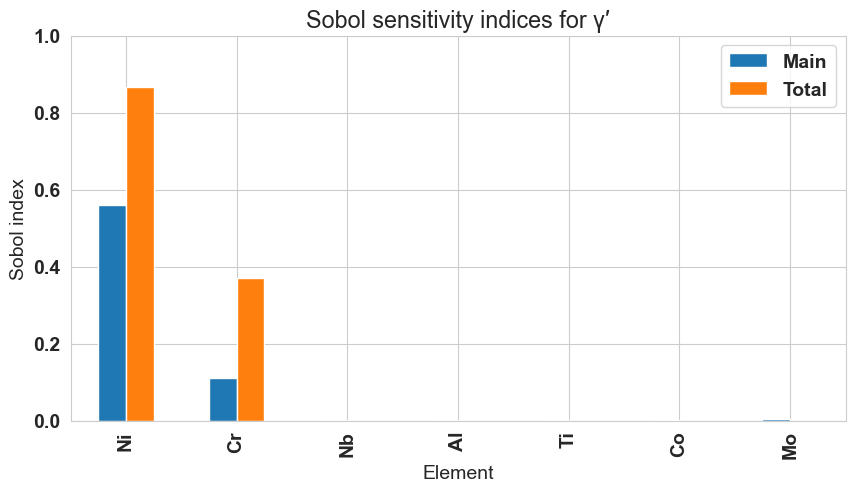

In [17]:
#8. Sobol sensitivity indices                                                 

main_sobol = cp.Sens_m(model_final, joint_dist)
total_sobol = cp.Sens_t(model_final, joint_dist)

elements = ['Ni', 'Cr', 'Nb', 'Al', 'Ti', 'Co', 'Mo']
sobol_df = pd.DataFrame({
    'Element': elements,
    'Main': main_sobol,
    'Total': total_sobol
})

display(sobol_df)

# Bar plot
sobol_df.set_index('Element').plot.bar(figsize=(10,5))
plt.title("Sobol sensitivity indices for γ′")
plt.ylabel("Sobol index")
plt.ylim(0, 1)
plt.show()